In [1]:
# import the necessary packages
import numpy as np
import cv2
from PIL import Image
from pylab import*

#### LBP特征图像

In [2]:
class LBP:
    def __init__(self):
        #revolve_map为旋转不变模式的36种特征值从小到大进行序列化编号得到的字典
        self.revolve_map={0:0,1:1,3:2,5:3,7:4,9:5,11:6,13:7,15:8,17:9,19:10,21:11,23:12,
                          25:13,27:14,29:15,31:16,37:17,39:18,43:19,45:20,47:21,51:22,53:23,55:24,
                          59:25,61:26,63:27,85:28,87:29,91:30,95:31,111:32,119:33,127:34,255:35}
        #uniform_map为等价模式的58种特征值从小到大进行序列化编号得到的字典
        self.uniform_map={0:0,1:1,2:2,3:3,4:4,6:5,7:6,8:7,12:8,
                          14:9,15:10,16:11,24:12,28:13,30:14,31:15,32:16,
                          48:17,56:18,60:19,62:20,63:21,64:22,96:23,112:24,
                          120:25,124:26,126:27,127:28,128:29,129:30,131:31,135:32,
                          143:33,159:34,191:35,192:36,193:37,195:38,199:39,207:40,
                          223:41,224:42,225:43,227:44,231:45,239:46,240:47,241:48,
                          243:49,247:50,248:51,249:52,251:53,252:54,253:55,254:56,
                          255:57}

        
     #将图像载入，并转化为灰度图，获取图像灰度图的像素信息   
    def describe(self,image):
        image_array=np.array(Image.open(image).convert('L'))
        return image_array
    
    #图像的LBP原始特征计算算法：将图像指定位置的像素与周围8个像素比较
    #比中心像素大的点赋值为1，比中心像素小的赋值为0，返回得到的二进制序列
    def calute_basic_lbp(self,image_array,i,j):
        sum=[]
        if image_array[i-1,j-1]>image_array[i,j]:
            sum.append(1)
        else:
            sum.append(0)
        if image_array[i-1,j]>image_array[i,j]:
            sum.append(1)
        else:
            sum.append(0)
        if image_array[i-1,j+1]>image_array[i,j]:
            sum.append(1)
        else:
            sum.append(0)
        if image_array[i,j-1]>image_array[i,j]:
            sum.append(1)
        else:
            sum.append(0)
        if image_array[i,j+1]>image_array[i,j]:
            sum.append(1)
        else:
            sum.append(0)
        if image_array[i+1,j-1]>image_array[i,j]:
            sum.append(1)
        else:
            sum.append(0)
        if image_array[i+1,j]>image_array[i,j]:
            sum.append(1)
        else:
            sum.append(0)
        if image_array[i+1,j+1]>image_array[i,j]:
            sum.append(1)
        else:
            sum.append(0)
        return sum
    
    #获取二进制序列进行不断环形旋转得到新的二进制序列的最小十进制值
    def get_min_for_revolve(self,arr): 
        values=[]
        circle=arr
        circle.extend(arr)
        for i in range(0,8):
            j=0
            sum=0
            bit_num=0
            while j<8:
                sum+=circle[i+j]<<bit_num
                bit_num+=1
                j+=1
            values.append(sum)
        return min(values)

    #获取值r的二进制中1的位数
    def calc_sum(self,r):
        num=0
        while(r):
            r&=(r-1)
            num+=1
        return num

    #获取图像的LBP原始模式特征
    def lbp_basic(self,image_array):
        basic_array=np.zeros(image_array.shape, np.uint8)
        width=image_array.shape[0]
        height=image_array.shape[1]
        for i in range(1,width-1):
            for j in range(1,height-1):
                sum=self.calute_basic_lbp(image_array,i,j)
                bit_num=0
                result=0
                for s in sum:
                    result+=s<<bit_num
                    bit_num+=1
                basic_array[i,j]=result
        return basic_array

   #获取图像的LBP旋转不变模式特征
    def lbp_revolve(self,image_array):
        revolve_array=np.zeros(image_array.shape, np.uint8)
        width=image_array.shape[0]
        height=image_array.shape[1]
        for i in range(1,width-1):
            for j in range(1,height-1):
                sum=self.calute_basic_lbp(image_array,i,j)
                revolve_key=self.get_min_for_revolve(sum)
                revolve_array[i,j]=self.revolve_map[revolve_key]
        return revolve_array

  #获取图像的LBP等价模式特征
    def lbp_uniform(self,image_array):
        uniform_array=np.zeros(image_array.shape, np.uint8)
        basic_array=self.lbp_basic(image_array)
        width=image_array.shape[0]
        height=image_array.shape[1]

        for i in range(1,width-1):
            for j in range(1,height-1):
                 k= basic_array[i,j]<<1
                 if k>255:
                     k=k-255
                 xor=basic_array[i,j]^k
                 num=self.calc_sum(xor)
                 if num<=2:
                     uniform_array[i,j]=self.uniform_map[basic_array[i,j]]
                 else:
                     uniform_array[i,j]=58
        return uniform_array
    
    #获取图像的LBP旋转不变等价模式特征
    def lbp_revolve_uniform(self,image_array):
        uniform_revolve_array=np.zeros(image_array.shape, np.uint8)
        basic_array=self.lbp_basic(image_array)
        width=image_array.shape[0]
        height=image_array.shape[1]
        for i in range(1,width-1):
            for j in range(1,height-1):
                 k= basic_array[i,j]<<1
                 if k>255:
                     k=k-255
                 xor=basic_array[i,j]^k
                 num=self.calc_sum(xor)
                 if num<=2:
                     uniform_revolve_array[i,j]=self.calc_sum(basic_array[i,j])
                 else:
                     uniform_revolve_array[i,j]=9
        return uniform_revolve_array

    #绘制指定维数和范围的图像灰度归一化统计直方图
    def show_hist(self,img_array,im_bins,im_range):
        hist = cv2.calcHist([img_array],[0],None,im_bins,im_range)
        hist = cv2.normalize(hist,None).flatten()
        plt.plot(hist,color = 'r')
        plt.xlim(im_range)
        plt.show()
        
    #绘制图像原始LBP特征的归一化统计直方图  
    def show_basic_hist(self,img_array):
        self.show_hist(img_array,[256],[0,256])
        
    #绘制图像旋转不变LBP特征的归一化统计直方图     
    def show_revolve_hist(self,img_array):
        self.show_hist(img_array,[36],[0,36])

    #绘制图像等价模式LBP特征的归一化统计直方图     
    def show_uniform_hist(self,img_array):
        self.show_hist(img_array,[60],[0,60])
        
    #绘制图像旋转不变等价模式LBP特征的归一化统计直方图     
    def show_revolve_uniform_hist(self,img_array):
        self.show_hist(img_array,[10],[0,10])

    #显示图像
    def show_image(self,image_array):
        cv2.imshow('Image',image_array)
        cv2.waitKey(0)

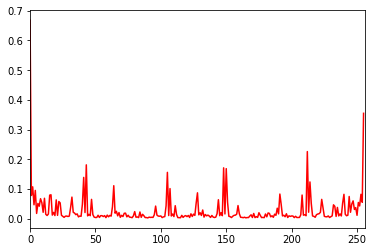

In [ ]:
if __name__ == '__main__':
    image = r"lena.png";
    lbp=LBP()
    image_array=lbp.describe(image)
    
    #获取图像原始LBP特征，并显示其统计直方图与特征图像
    basic_array=lbp.lbp_basic(image_array)
    lbp.show_basic_hist(basic_array)
    lbp.show_image(basic_array)

    #获取图像旋转不变LBP特征，并显示其统计直方图与特征图像
    #revolve_array=lbp.lbp_revolve(image_array)
    #lbp.show_revolve_hist(revolve_array)
    #lbp.show_image(revolve_array)

    #获取图像等价模式LBP特征，并显示其统计直方图与特征图像
    #uniform_array=lbp.lbp_uniform(image_array)
    #lbp.show_uniform_hist(uniform_array)
    #lbp.show_image(uniform_array)

    #获取图像等价模式LBP特征，并显示其统计直方图与特征图像
    #resolve_uniform_array=lbp.lbp_revolve_uniform(image_array)
    #lbp.show_revolve_uniform_hist(resolve_uniform_array)
    #lbp.show_image(resolve_uniform_array)